In [33]:
import os
import re
import json
import matplotlib.cm as cm
import numpy as np
import matplotlib.pyplot as plt

In [34]:
def list_files(directory, extension:str=".npz"):
    """Liste tous les fichiers .npz dans le dossier spécifié."""
    return [f for f in os.listdir(directory) if f.endswith(extension)]

In [35]:
def load_and_process_flat(file_name : str,
                          base_path,
                          layer_name : str = "layer_40"):
    data = np.load(f"{base_path}/heatmap/{file_name}")
    heatmaps = data[layer_name]
    heatmaps = np.abs(heatmaps)
    heatmaps_flat = heatmaps.reshape(heatmaps.shape[0], -1)
    return heatmaps, heatmaps_flat

In [36]:
def get_feature_per_cluster(data, best_number_cluster, best_method, picture_name, base_path):
    cluster_label = data[f"{best_number_cluster}_{best_method}"]
    index_in_each_cluster = indices_par_valeur(cluster_label)
    heatmaps, _ = load_and_process_flat(picture_name, base_path, layer_name="layer_40")
    heatmaps_by_cluster = {}
    vmin, vmax = float("inf"), float("-inf")
    for cluster in set(cluster_label):
        if cluster == -1:
            continue
        indices = np.where(cluster_label == cluster)[0]
        cluster_heatmaps = heatmaps[indices]
        heatmaps_by_cluster[cluster] = cluster_heatmaps

        if cluster_heatmaps.shape[0] > 0:
            combined_heatmap = np.sum(cluster_heatmaps, axis=0)
            vmin = min(vmin, combined_heatmap.min())
            vmax = max(vmax, combined_heatmap.max())
    return heatmaps_by_cluster, vmin, vmax, index_in_each_cluster

In [37]:
def indices_par_valeur(lst):
    arr = np.array(lst)
    return {val: np.where(arr == val)[0].tolist() for val in np.unique(arr)}

In [38]:
def get_filename_without_extension(path: str) -> str:
    return os.path.splitext(os.path.basename(path))[0]

In [39]:
def get_all_different_element_in_cluster_meaning(dictionnary_file_to_clusters_meaning):
    all_values = []
    for key_file_name in dictionnary_file_to_clusters_meaning:
        for _, value in dictionnary_file_to_clusters_meaning[key_file_name].items():
            if value not in all_values:
                all_values.append(value)
    return all_values

In [40]:
def extract_code(filename: str) -> str:
    match = re.match(r"(n\d+)_", filename)
    return match.group(1) if match else ""

In [41]:
def reverse_dict_list(d):
    reversed_dict = {}
    for key, values in d.items():
        for value in values:
            reversed_dict[value] = key
    return reversed_dict

In [42]:
def get_colors(n, cmap_name='tab10'):
    cmap = cm.get_cmap(cmap_name, n)  # Obtenir la colormap avec n couleurs distinctes
    return [cmap(i) for i in range(n)]

In [43]:
def compare_2_dict(dictionary_comparison_2_files : dict,
                           list_colors : list = None,
                           dictionary_class_index : dict = None):
    file_name1, file_name2 = dictionary_comparison_2_files[FILE_NAME_CONST]
    index_in_each_cluster1, index_in_each_cluster2 = dictionary_comparison_2_files[INDEX_IN_EACH_CLUSTER_CONST]
    dict_equivalence1, dict_equivalence2 = dictionary_comparison_2_files[DICTIONARY_EQUIVALENCE_CONST]
    all_values = dictionary_comparison_2_files[ALL_VALUES_CONST]
    class_name_1 = extract_code(file_name1)
    class_name_2 = extract_code(file_name2)
    if list_colors is None:
        list_colors = get_colors(len(index_in_each_cluster2))
    if dictionary_class_index is None:
        class_name_1 = ""
        class_name_2 = ""
    else :
        class_name_1 = dictionary_class_index[class_name_1]
        class_name_2 = dictionary_class_index[class_name_2]

    reversed_dict_1 = reverse_dict_list(index_in_each_cluster1)
    global_dict = {class_name: [0] * len(index_in_each_cluster2) for class_name in all_values}

    for i, (key2, indices) in enumerate(index_in_each_cluster2.items()):
        for index in indices:
            class_name_dict1 = dict_equivalence1.get(reversed_dict_1.get(index))
            if class_name_dict1:
                global_dict[class_name_dict1][i] += 1

    x = range(len(all_values))
    bottom = [0] * len(all_values)

    plt.figure(figsize=(10, 6))

    for i, (key2, color) in enumerate(zip(index_in_each_cluster2.keys(), list_colors)):
        values = [global_dict[class_name][i] for class_name in all_values]
        bars = plt.bar(x, values, bottom=bottom, label=dict_equivalence2[key2], color=color)

        for bar, value in zip(bars, values):
            if value > 0:
                plt.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2,
                         str(value), ha='center', va='center', fontsize=9, color='black')

        bottom = [b + v for b, v in zip(bottom, values)]

    for i, total in enumerate(bottom):
        if total > 0:
            plt.text(i, total, str(total), ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.xticks(x, all_values, rotation=45)
    plt.xlabel(f"Classes de {file_name1} ({class_name_1})")
    plt.ylabel(f"Nombre d'éléments")
    plt.title(f"Comparaison des classes entre {file_name1} ({class_name_1}) et {file_name2} ({class_name_2})")
    plt.legend(title=f"Classes de {file_name2} ({class_name_2})")
    plt.tight_layout()
    plt.show()

In [44]:
def compare_X_dict(dictionnary_file_to_clusters_meaning: dict,
                  dictionary_file_to_index_in_each_cluster: dict,
                  all_values: list,
                  base_path: str,
                  save_name_prefix: str,
                  list_colors: list = None,
                  dictionary_class_index: dict = None,
                  seuil_to_None: int = 1,
                  seuil_is_mean: bool = False,
                  save_files: bool = True):
    
    # Ajout de compteurs de debug
    total_features_initial = 0
    features_processed = set()
    
    class_name_to_id = {class_name: i for i, class_name in enumerate(all_values)}
    class_id_to_name = {i: class_name for i, class_name in enumerate(all_values)}
    
    global_dict = {class_name: [0] * (len(list(dictionnary_file_to_clusters_meaning.keys()))+1) for class_name in all_values}
    local_dict = {}
    
    # Première passe : compter toutes les features
    for file_name in dictionnary_file_to_clusters_meaning.keys():
        for class_id in dictionary_file_to_index_in_each_cluster[file_name].keys():
            list_feature_id = dictionary_file_to_index_in_each_cluster[file_name][class_id]
            total_features_initial += len(list_feature_id)
            
            for feature_id in list_feature_id:
                if feature_id not in local_dict:
                    local_dict[feature_id] = [0] * len(all_values)
                features_processed.add(feature_id)
                
                class_name = dictionnary_file_to_clusters_meaning[file_name][class_id]
                class_id_numeric = class_name_to_id[class_name]
                local_dict[feature_id][class_id_numeric] += 1
    
    print(f"Nombre total de features initial: {total_features_initial}")
    print(f"Nombre de features uniques traitées: {len(features_processed)}")
    
    if seuil_is_mean:
        seuil_to_None = len(dictionnary_file_to_clusters_meaning.keys()) // 2
    
    print(f"Seuil utilisé pour None: {seuil_to_None}")
    
    features_assigned = 0
    local_dict_max = {}
    class_id_to_all_features = {class_name: [] for class_name in all_values}
    
    for feature_id, occurrences in local_dict.items():
        max_occurrences = max(occurrences)
        best_index = occurrences.index(max_occurrences)
        
        if max_occurrences <= seuil_to_None:
            best_index = class_name_to_id[CLUSTER_FEATURE_NONE]
        
        features_assigned += 1
        local_dict_max[feature_id] = (best_index, max_occurrences)
        class_name = class_id_to_name[best_index]
        class_id_to_all_features[class_name].append(feature_id)
        
        if max_occurrences < len(global_dict[class_name]):
            global_dict[class_name][max_occurrences] += 1
    
    print(f"Nombre de features assignées: {features_assigned}")
    
    # Afficher la distribution des features par classe
    for class_name, features in class_id_to_all_features.items():
        print(f"{class_name}: {len(features)} features")

    if save_files:
        try:
            # Création du répertoire de sauvegarde si nécessaire
            save_dir = os.path.join(base_path, "clusters_analysis")
            os.makedirs(save_dir, exist_ok=True)
            
            # 1. Sauvegarde du nombre d'occurrences par classe
            save_path = os.path.join(save_dir, f"{save_name_prefix}_{SUFFIX_NB_LEVEL_OCCURENCE_PER_CLASS}.npz")
            np.savez(save_path, **global_dict)
            print(f"Saved occurrences per class to: {save_path}")

            # 2. Sauvegarde des classes et occurrences par feature
            save_path = os.path.join(save_dir, f"{save_name_prefix}_{SUFFIX_CLASS_AND_OCCURENCE_PER_FEATURE}.npz")
            # Conversion des tuples en liste pour la sauvegarde
            save_dict = {str(k): list(v) for k, v in local_dict_max.items()}
            np.savez(save_path, **save_dict)
            print(f"Saved class and occurrence per feature to: {save_path}")

            # 3. Sauvegarde de toutes les features par classe
            save_path = os.path.join(save_dir, f"{save_name_prefix}_{SUFFIX_ALL_FEATURE_IN_EACH_CLASS}.npz")
            # Conversion en array numpy pour chaque classe
            save_dict = {str(k): np.array(v) for k, v in class_id_to_all_features.items()}
            np.savez(save_path, **save_dict)
            print(f"Saved all features per class to: {save_path}")

            # Vérification des fichiers sauvegardés
            for suffix in [SUFFIX_NB_LEVEL_OCCURENCE_PER_CLASS, 
                         SUFFIX_CLASS_AND_OCCURENCE_PER_FEATURE,
                         SUFFIX_ALL_FEATURE_IN_EACH_CLASS]:
                check_path = os.path.join(save_dir, f"{save_name_prefix}_{suffix}.npz")
                if os.path.exists(check_path):
                    # Vérification que le fichier est lisible
                    with np.load(check_path) as data:
                        if len(data.files) == 0:
                            print(f"Warning: Empty file saved at {check_path}")
                else:
                    print(f"Error: File not saved at {check_path}")

        except Exception as e:
            print(f"Error during save process: {str(e)}")
            raise e  # Re-raise l'exception pour ne pas masquer les erreurs

    if list_colors is None:
        cmap = plt.get_cmap('viridis')
        num_occurrences = len(list(dictionnary_file_to_clusters_meaning.keys())) + 1
        list_colors = [cmap(i / num_occurrences) for i in range(num_occurrences)]

    class_names = list(global_dict.keys())
    occurrence_levels = list(range(len(list(dictionnary_file_to_clusters_meaning.keys())) + 1))
    bottom = [0] * len(class_names)

    plt.figure(figsize=(15, 8))  # Augmentation de la taille du graphique

    # Création du graphique avec les modifications
    for occ_level in occurrence_levels:
        values = [global_dict[class_name][occ_level] for class_name in class_names]
        if any(values):  # Ne tracer que si au moins une valeur existe pour ce niveau
            bars = plt.bar(class_names, values, bottom=bottom, 
                         color=list_colors[occ_level % len(list_colors)],
                         label=f"{occ_level} occurrence{'s' if occ_level != 1 else ''}")

            # Ajout des étiquettes de valeurs
            for bar, value in zip(bars, values):
                if value > 0:  # N'afficher que les valeurs positives
                    height = bar.get_height()
                    plt.text(bar.get_x() + bar.get_width()/2, 
                           bar.get_y() + height/2,
                           str(value), 
                           ha='center', 
                           va='center',
                           fontsize=8,
                           rotation=0 if height > 20 else 90)  # Rotation du texte si la barre est étroite

            bottom = [b + v for b, v in zip(bottom, values)]

    # Ajout des totaux au-dessus des barres
    for i, total in enumerate(bottom):
        if total > 0:
            plt.text(i, total, f'Total: {total}', 
                    ha='center', 
                    va='bottom',
                    fontsize=10,
                    fontweight='bold')

    plt.xlabel('Classes')
    plt.ylabel('Nombre de caractéristiques')
    plt.title('Distribution des occurrences par classe')
    plt.xticks(rotation=45, ha='right')
    
    # Ajustement de la légende
    plt.legend(title="Nombre d'occurrences",
              bbox_to_anchor=(1.05, 1),
              loc='upper left',
              borderaxespad=0.)
    
    # Ajustement des marges pour s'assurer que tout est visible
    plt.tight_layout()
    
    # Affichage des statistiques totales
    total_features = sum(sum(values) for values in global_dict.values())
    print(f"\nStatistiques totales:")
    print(f"Nombre total de caractéristiques: {total_features}")
    for class_name in class_names:
        total_class = sum(global_dict[class_name])
        print(f"{class_name}: {total_class} caractéristiques")

    plt.show()



In [ ]:
def compare_X_dictv2(dictionnary_file_to_clusters_meaning: dict,
                  dictionary_file_to_index_in_each_cluster: dict,
                  all_values: list,
                  base_path: str,
                  save_name_prefix: str,
                  list_colors: list = None,
                  dictionary_class_index: dict = None,
                  seuil_to_None: int = 1,
                  seuil_is_mean: bool = False,
                  save_files: bool = True):

    # Ajout de compteurs de debug
    total_features_initial = 0
    features_processed = set()

    class_name_to_id = {class_name: i for i, class_name in enumerate(all_values)}
    class_id_to_name = {i: class_name for i, class_name in enumerate(all_values)}

    global_dict = {class_name: [0] * (len(list(dictionnary_file_to_clusters_meaning.keys()))+1) for class_name in all_values}
    local_dict = {}

    # Première passe : compter toutes les features
    for file_name in dictionnary_file_to_clusters_meaning.keys():
        for class_id in dictionary_file_to_index_in_each_cluster[file_name].keys():
            list_feature_id = dictionary_file_to_index_in_each_cluster[file_name][class_id]
            total_features_initial += len(list_feature_id)

            for feature_id in list_feature_id:
                if feature_id not in local_dict:
                    local_dict[feature_id] = [0] * len(all_values)
                features_processed.add(feature_id)

                class_name = dictionnary_file_to_clusters_meaning[file_name][class_id]
                class_id_numeric = class_name_to_id[class_name]
                local_dict[feature_id][class_id_numeric] += 1

    print(f"Nombre total de features initial: {total_features_initial}")
    print(f"Nombre de features uniques traitées: {len(features_processed)}")

    if seuil_is_mean:
        seuil_to_None = len(dictionnary_file_to_clusters_meaning.keys()) // 2

    print(f"Seuil utilisé pour None: {seuil_to_None}")

    features_assigned = 0
    local_dict_max = {}
    class_id_to_all_features = {class_name: [] for class_name in all_values}

    for feature_id, occurrences in local_dict.items():
        max_occurrences = max(occurrences)
        best_index = occurrences.index(max_occurrences)
        class_name = class_id_to_name[best_index]
        if class_name == CLUSTER_FEATURE_NONE:
            occurrences[best_index] = 0
            max_occurrences = max(occurrences)
            best_index = occurrences.index(max_occurrences)


        if max_occurrences <= seuil_to_None:
            best_index = class_name_to_id[CLUSTER_FEATURE_NONE]

        features_assigned += 1
        local_dict_max[feature_id] = (best_index, max_occurrences)
        class_name = class_id_to_name[best_index]
        class_id_to_all_features[class_name].append(feature_id)

        if max_occurrences < len(global_dict[class_name]):
            global_dict[class_name][max_occurrences] += 1

    print(f"Nombre de features assignées: {features_assigned}")

    # Afficher la distribution des features par classe
    for class_name, features in class_id_to_all_features.items():
        print(f"{class_name}: {len(features)} features")

    if save_files:
        try:
            # Création du répertoire de sauvegarde si nécessaire
            save_dir = os.path.join(base_path, "clusters_analysis")
            os.makedirs(save_dir, exist_ok=True)

            # 1. Sauvegarde du nombre d'occurrences par classe
            save_path = os.path.join(save_dir, f"{save_name_prefix}_{SUFFIX_NB_LEVEL_OCCURENCE_PER_CLASS}.npz")
            np.savez(save_path, **global_dict)
            print(f"Saved occurrences per class to: {save_path}")

            # 2. Sauvegarde des classes et occurrences par feature
            save_path = os.path.join(save_dir, f"{save_name_prefix}_{SUFFIX_CLASS_AND_OCCURENCE_PER_FEATURE}.npz")
            # Conversion des tuples en liste pour la sauvegarde
            save_dict = {str(k): list(v) for k, v in local_dict_max.items()}
            np.savez(save_path, **save_dict)
            print(f"Saved class and occurrence per feature to: {save_path}")

            # 3. Sauvegarde de toutes les features par classe
            save_path = os.path.join(save_dir, f"{save_name_prefix}_{SUFFIX_ALL_FEATURE_IN_EACH_CLASS}.npz")
            # Conversion en array numpy pour chaque classe
            save_dict = {str(k): np.array(v) for k, v in class_id_to_all_features.items()}
            np.savez(save_path, **save_dict)
            print(f"Saved all features per class to: {save_path}")

            # Vérification des fichiers sauvegardés
            for suffix in [SUFFIX_NB_LEVEL_OCCURENCE_PER_CLASS,
                         SUFFIX_CLASS_AND_OCCURENCE_PER_FEATURE,
                         SUFFIX_ALL_FEATURE_IN_EACH_CLASS]:
                check_path = os.path.join(save_dir, f"{save_name_prefix}_{suffix}.npz")
                if os.path.exists(check_path):
                    # Vérification que le fichier est lisible
                    with np.load(check_path) as data:
                        if len(data.files) == 0:
                            print(f"Warning: Empty file saved at {check_path}")
                else:
                    print(f"Error: File not saved at {check_path}")

        except Exception as e:
            print(f"Error during save process: {str(e)}")
            raise e  # Re-raise l'exception pour ne pas masquer les erreurs

    if list_colors is None:
        cmap = plt.get_cmap('viridis')
        num_occurrences = len(list(dictionnary_file_to_clusters_meaning.keys())) + 1
        list_colors = [cmap(i / num_occurrences) for i in range(num_occurrences)]

    class_names = list(global_dict.keys())
    occurrence_levels = list(range(len(list(dictionnary_file_to_clusters_meaning.keys())) + 1))
    bottom = [0] * len(class_names)

    plt.figure(figsize=(15, 8))  # Augmentation de la taille du graphique

    # Création du graphique avec les modifications
    for occ_level in occurrence_levels:
        values = [global_dict[class_name][occ_level] for class_name in class_names]
        if any(values):  # Ne tracer que si au moins une valeur existe pour ce niveau
            bars = plt.bar(class_names, values, bottom=bottom,
                         color=list_colors[occ_level % len(list_colors)],
                         label=f"{occ_level} occurrence{'s' if occ_level != 1 else ''}")

            # Ajout des étiquettes de valeurs
            for bar, value in zip(bars, values):
                if value > 0:  # N'afficher que les valeurs positives
                    height = bar.get_height()
                    plt.text(bar.get_x() + bar.get_width()/2,
                           bar.get_y() + height/2,
                           str(value),
                           ha='center',
                           va='center',
                           fontsize=8,
                           rotation=0 if height > 20 else 90)  # Rotation du texte si la barre est étroite

            bottom = [b + v for b, v in zip(bottom, values)]

    # Ajout des totaux au-dessus des barres
    for i, total in enumerate(bottom):
        if total > 0:
            plt.text(i, total, f'Total: {total}',
                    ha='center',
                    va='bottom',
                    fontsize=10,
                    fontweight='bold')

    plt.xlabel('Classes')
    plt.ylabel('Nombre de caractéristiques')
    plt.title('Distribution des occurrences par classe')
    plt.xticks(rotation=45, ha='right')

    # Ajustement de la légende
    plt.legend(title="Nombre d'occurrences",
              bbox_to_anchor=(1.05, 1),
              loc='upper left',
              borderaxespad=0.)

    # Ajustement des marges pour s'assurer que tout est visible
    plt.tight_layout()

    # Affichage des statistiques totales
    total_features = sum(sum(values) for values in global_dict.values())
    print(f"\nStatistiques totales:")
    print(f"Nombre total de caractéristiques: {total_features}")
    for class_name in class_names:
        total_class = sum(global_dict[class_name])
        print(f"{class_name}: {total_class} caractéristiques")

    plt.show()



In [45]:
SUFFIX_NB_LEVEL_OCCURENCE_PER_CLASS = "nb_level_occurence_per_class"
SUFFIX_CLASS_AND_OCCURENCE_PER_FEATURE = "class_and_occurence_per_feature"
SUFFIX_ALL_FEATURE_IN_EACH_CLASS = "all_feature_in_each_class"

In [46]:
GMM_CONST = "GMM"
KMEANS_CONST = "KMeans"
SPECTRAL_CONST = "SpectralClustering"
AGGLOMERATIVE_CONST = "AgglomerativeClustering"
HDBSCAN_CONST = "HDBSCAN"

In [47]:
CLUSTER_FEATURE_NONE = "None"
CLUSTER_FEATURE_EYE = "Eye"
CLUSTER_FEATURE_HEAD = "Head"
CLUSTER_FEATURE_BODY = "Body"
CLUSTER_FEATURE_BEAK = "Beak"
CLUSTER_FEATURE_WING = "Wing"
CLUSTER_FEATURE_TAIL = "Tail"
CLUSTER_FEATURE_LEG = "Leg"
CLUSTER_FEATURE_HORN = "Horn"
CLUSTER_FEATURE_FRONT = "Front"
CLUSTER_FEATURE_BACK = "Back"
CLUSTER_FEATURE_SECOND_ANIMAL = "Second_animal"
CLUSTER_FEATURE_EAR = "Ear"

CLUSTER_FEATURE_EAR = CLUSTER_FEATURE_HORN
CLUSTER_FEATURE_TAIL = CLUSTER_FEATURE_BACK
CLUSTER_FEATURE_FRONT = CLUSTER_FEATURE_LEG
CLUSTER_FEATURE_SECOND_ANIMAL = CLUSTER_FEATURE_BODY

In [48]:

dictionary_file_to_best_clustering = {
    "n02423022_1601": (3, KMEANS_CONST),
    "n02423022_1721": (6,KMEANS_CONST),
    "n02423022_219": (5, KMEANS_CONST),
    "n02423022_425": (7, KMEANS_CONST),
    "n02423022_950": (8, KMEANS_CONST),
    "n02423022_1719": (4, KMEANS_CONST),
    "n02423022_2853": (9, KMEANS_CONST),
    "n02423022_3333": (5, KMEANS_CONST),
    "n02423022_26471": (7,KMEANS_CONST),
    "n02423022_39890": (6,KMEANS_CONST),
    "n02423022_976": (3, KMEANS_CONST),
    "n02423022_26532": (4,KMEANS_CONST),
    "n02423022_3614": (8,KMEANS_CONST),
    "n02423022_933": (13,KMEANS_CONST),
    "n02423022_418": (3, KMEANS_CONST),
    "n02423022_11080": (7, KMEANS_CONST),
    "n02423022_233": (3, KMEANS_CONST),
    "n02423022_9189": (6, KMEANS_CONST),
    "n02423022_2640": (3, KMEANS_CONST),
}

In [49]:
dictionnary_file_to_clusters_meaning = {
    "n02423022_219" : {
        0: CLUSTER_FEATURE_NONE,
        1: CLUSTER_FEATURE_EYE,
        2: CLUSTER_FEATURE_HORN,
        3: CLUSTER_FEATURE_FRONT,
        4: CLUSTER_FEATURE_BACK,
    },
    "n02423022_233" : {
        0: CLUSTER_FEATURE_NONE,
        1: CLUSTER_FEATURE_BACK,
        2: CLUSTER_FEATURE_EYE,
    },
    "n02423022_418" : {
        0: CLUSTER_FEATURE_NONE,
        1: CLUSTER_FEATURE_HORN,
        2: CLUSTER_FEATURE_EYE, #nose
    },
    "n02423022_425" : {
        0: CLUSTER_FEATURE_NONE,
        1: CLUSTER_FEATURE_BODY,
        2: CLUSTER_FEATURE_NONE,
        3: CLUSTER_FEATURE_EYE,
        4: CLUSTER_FEATURE_BACK,
        5: CLUSTER_FEATURE_NONE,
        6: CLUSTER_FEATURE_BACK,
    },
    "n02423022_933" : {
        0: CLUSTER_FEATURE_NONE,
        1: CLUSTER_FEATURE_EYE,
        2: CLUSTER_FEATURE_LEG,
        3: CLUSTER_FEATURE_NONE,
        4: CLUSTER_FEATURE_NONE,
        5: CLUSTER_FEATURE_HORN,
        6: CLUSTER_FEATURE_NONE,
        7: CLUSTER_FEATURE_NONE,
        8: CLUSTER_FEATURE_NONE,
        9: CLUSTER_FEATURE_BACK,
        10: CLUSTER_FEATURE_NONE,
        11: CLUSTER_FEATURE_NONE,
        12: CLUSTER_FEATURE_NONE,
    },
    "n02423022_950" : {
        0: CLUSTER_FEATURE_FRONT,
        1: CLUSTER_FEATURE_HORN,
        2: CLUSTER_FEATURE_NONE,
        3: CLUSTER_FEATURE_NONE,
        4: CLUSTER_FEATURE_NONE,
        5: CLUSTER_FEATURE_EYE,
        6: CLUSTER_FEATURE_SECOND_ANIMAL, #autre animal
        7: CLUSTER_FEATURE_BACK,
    },
    "n02423022_976" : {
        0: CLUSTER_FEATURE_NONE,
        1: CLUSTER_FEATURE_EYE,
        2: CLUSTER_FEATURE_LEG,
    },
    "n02423022_1601" : {
        0: CLUSTER_FEATURE_FRONT,
        1: CLUSTER_FEATURE_EYE,
        2: CLUSTER_FEATURE_BACK,
    },
    "n02423022_1719" : {
        0: CLUSTER_FEATURE_NONE,
        1: CLUSTER_FEATURE_LEG,
        2: CLUSTER_FEATURE_EYE,
        3: CLUSTER_FEATURE_BACK
    },
    "n02423022_1721" : {
        0: CLUSTER_FEATURE_HORN,
        1: CLUSTER_FEATURE_EYE,
        2: CLUSTER_FEATURE_BACK,
        3: CLUSTER_FEATURE_NONE,
        4: CLUSTER_FEATURE_HORN,
        5: CLUSTER_FEATURE_NONE
    },
    "n02423022_2640" : {
        0: CLUSTER_FEATURE_EYE,
        1: CLUSTER_FEATURE_BACK,
        2: CLUSTER_FEATURE_NONE,
    },
    "n02423022_2853" : {
        0: CLUSTER_FEATURE_HORN,
        1: CLUSTER_FEATURE_NONE, #penis en vrai
        2: CLUSTER_FEATURE_BACK,
        3: CLUSTER_FEATURE_NONE,
        4: CLUSTER_FEATURE_EYE,
        5: CLUSTER_FEATURE_HORN,
        6: CLUSTER_FEATURE_NONE,
        7: CLUSTER_FEATURE_NONE,
        8: CLUSTER_FEATURE_NONE,
    },
    "n02423022_3333" : {
        0: CLUSTER_FEATURE_EYE,
        1: CLUSTER_FEATURE_BODY,
        2: CLUSTER_FEATURE_NONE,
        3: CLUSTER_FEATURE_NONE,
        4: CLUSTER_FEATURE_LEG,
    },
    "n02423022_3614" : {
        0: CLUSTER_FEATURE_NONE,
        1: CLUSTER_FEATURE_EYE,
        2: CLUSTER_FEATURE_LEG,
        3: CLUSTER_FEATURE_NONE,
        4: CLUSTER_FEATURE_TAIL,
        5: CLUSTER_FEATURE_NONE,
        6: CLUSTER_FEATURE_NONE,
        7: CLUSTER_FEATURE_NONE,
    },
    "n02423022_9189" : {
        0: CLUSTER_FEATURE_HORN,
        1: CLUSTER_FEATURE_EYE,
        2: CLUSTER_FEATURE_EAR,
        3: CLUSTER_FEATURE_NONE,
        4: CLUSTER_FEATURE_EYE,
        5: CLUSTER_FEATURE_NONE,
    },
    "n02423022_11080" : {
        0: CLUSTER_FEATURE_NONE,
        1: CLUSTER_FEATURE_BACK,
        2: CLUSTER_FEATURE_NONE,
        3: CLUSTER_FEATURE_LEG,
        4: CLUSTER_FEATURE_BACK,
        5: CLUSTER_FEATURE_EYE,
        6: CLUSTER_FEATURE_EYE,
    },
    "n02423022_26471" : {
        0: CLUSTER_FEATURE_EYE,
        1: CLUSTER_FEATURE_BODY,
        2: CLUSTER_FEATURE_NONE,
        3: CLUSTER_FEATURE_HORN,
        4: CLUSTER_FEATURE_NONE,
        5: CLUSTER_FEATURE_NONE,
        6: CLUSTER_FEATURE_LEG,
    },
    "n02423022_26532" : {
        0: CLUSTER_FEATURE_NONE,
        1: CLUSTER_FEATURE_EYE,
        2: CLUSTER_FEATURE_LEG,
        3: CLUSTER_FEATURE_BACK,
    },
    "n02423022_39890" : {
        0: CLUSTER_FEATURE_HORN,
        1: CLUSTER_FEATURE_BACK,
        2: CLUSTER_FEATURE_EYE,
        3: CLUSTER_FEATURE_LEG,
        4: CLUSTER_FEATURE_NONE,
        5: CLUSTER_FEATURE_NONE,
    },
}

In [50]:
base_path = "./data/v6/clusters"

In [51]:
directory_clusters = f"{base_path}/clusters"
files_clusters = list_files(directory_clusters, extension=".npz")

In [52]:
with open(f"{base_path}/imagenet_class_index_reversed.json", "r") as file:
    dictionary_class_index = json.load(file)

In [53]:
dictionary_file_to_index_in_each_cluster = {}
for picture_name in dictionary_file_to_best_clustering.keys():
    file_path_cluster = f"{directory_clusters}/clusters_{picture_name}.npz"
    if not os.path.exists(file_path_cluster):
        print(f"File {file_path_cluster} does not exist.")
        continue
    best_number_cluster, best_method = dictionary_file_to_best_clustering[picture_name]
    data = np.load(file_path_cluster)
    heatmap_file = f"{picture_name}.npz"
    _, _, _, index_in_each_cluster = get_feature_per_cluster(data, best_number_cluster, best_method, heatmap_file, base_path)
    dictionary_file_to_index_in_each_cluster[picture_name] = index_in_each_cluster

In [54]:
all_values = get_all_different_element_in_cluster_meaning(dictionnary_file_to_clusters_meaning)

In [55]:
colors = [
    "#E6194B",  # Rouge vif
    "#3CB44B",  # Vert vif
    "#FFE119",  # Jaune
    "#4363D8",  # Bleu vif
    "#F58231",  # Orange
    "#911EB4",  # Violet
    "#46F0F0",  # Cyan
    "#F032E6",  # Rose
    "#BCF60C",  # Vert clair
    "#FABEBE"   # Rose clair
]

In [56]:
FILE_NAME_CONST = "file_name"
INDEX_IN_EACH_CLUSTER_CONST = "index_in_each_cluster"
DICTIONARY_EQUIVALENCE_CONST = "dictionary_equivalence"
ALL_VALUES_CONST = "all_values"

In [57]:
dictionary_comparison_2_files = {}

If you want to compare two files, you can use the following code.

In [58]:
first_picture_to_compare = "n02423022_6092"
second_picture_to_compare = "n02423022_11080"

In [59]:
index_in_each_cluster_1 = dictionary_file_to_index_in_each_cluster[first_picture_to_compare]
index_in_each_cluster_2 = dictionary_file_to_index_in_each_cluster[second_picture_to_compare]

In [60]:
dict_equivalence_1 = dictionnary_file_to_clusters_meaning[first_picture_to_compare]
dict_equivalence_2 = dictionnary_file_to_clusters_meaning[second_picture_to_compare]

In [61]:
dictionary_comparison_2_files[FILE_NAME_CONST] = (first_picture_to_compare, second_picture_to_compare)
dictionary_comparison_2_files[INDEX_IN_EACH_CLUSTER_CONST] = (index_in_each_cluster_1, index_in_each_cluster_2)
dictionary_comparison_2_files[DICTIONARY_EQUIVALENCE_CONST] = (dict_equivalence_1, dict_equivalence_2)
dictionary_comparison_2_files[ALL_VALUES_CONST] = all_values

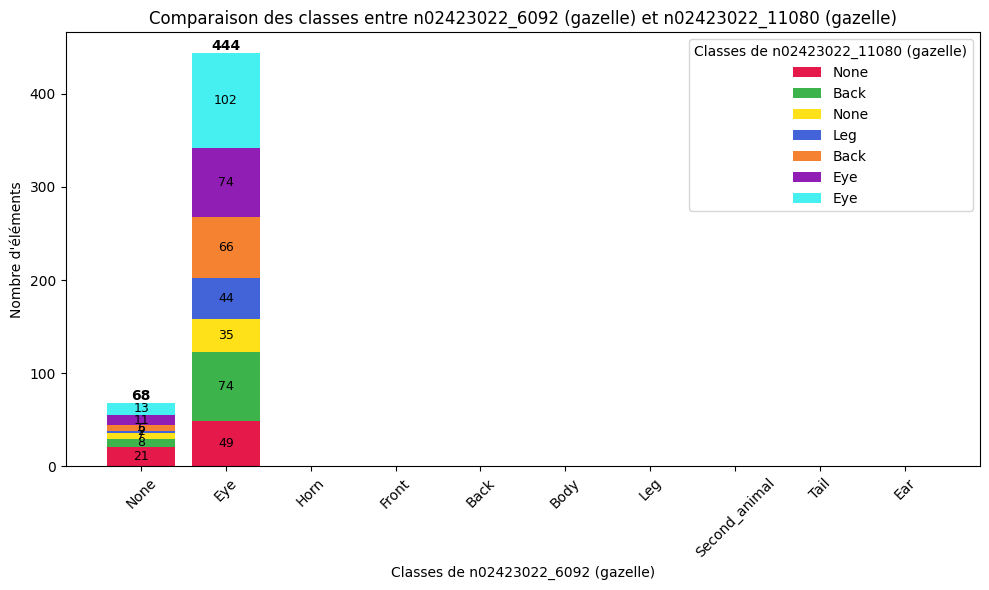

In [62]:
compare_2_dict(dictionary_comparison_2_files, list_colors= colors, dictionary_class_index=dictionary_class_index)

If you want to compare multiple file and each feature is assigned to the cluster where it is the most frequent, you can use the following code.
If it appears 1 times everywhere it is assigned to the None cluster
If it appears in equal proportion in multiple clusters, it is assigned to the first cluster where it appear in such proportion

Modifie le nom dans save_name_prefix pour modifier le nom sous lesquel ce sera sauvegardé (mets un truc pas trop long)
seuil_to_None permet de fdéfinir à partir de combien d'occurence on garde dans la class. Si par exemple tu mets 2 et que l'occurrence max d'une feature est 1 alors elle sera mise dans None
seuil_is_mean permet de remplacer seuil_to_None pour définir directement seuil_to_None comme étant la moyenne arrondi à l'inférieur du nombre de fichier traiter (le nombre de clef dns dictionnary_file_to_clusters_meaning)

Nombre total de features initial: 12800
Nombre de features uniques traitées: 512
Seuil utilisé pour None: 0
Nombre de features assignées: 512
None: 88 features
Eye: 381 features
Horn: 0 features
Front: 0 features
Back: 39 features
Body: 0 features
Leg: 4 features
Second_animal: 0 features
Tail: 0 features
Ear: 0 features
Saved occurrences per class to: ./data/v6/clusters/clusters_analysis/t1_nb_level_occurence_per_class.npz
Saved class and occurrence per feature to: ./data/v6/clusters/clusters_analysis/t1_class_and_occurence_per_feature.npz
Saved all features per class to: ./data/v6/clusters/clusters_analysis/t1_all_feature_in_each_class.npz

Statistiques totales:
Nombre total de caractéristiques: 512
None: 88 caractéristiques
Eye: 381 caractéristiques
Horn: 0 caractéristiques
Front: 0 caractéristiques
Back: 39 caractéristiques
Body: 0 caractéristiques
Leg: 4 caractéristiques
Second_animal: 0 caractéristiques
Tail: 0 caractéristiques
Ear: 0 caractéristiques


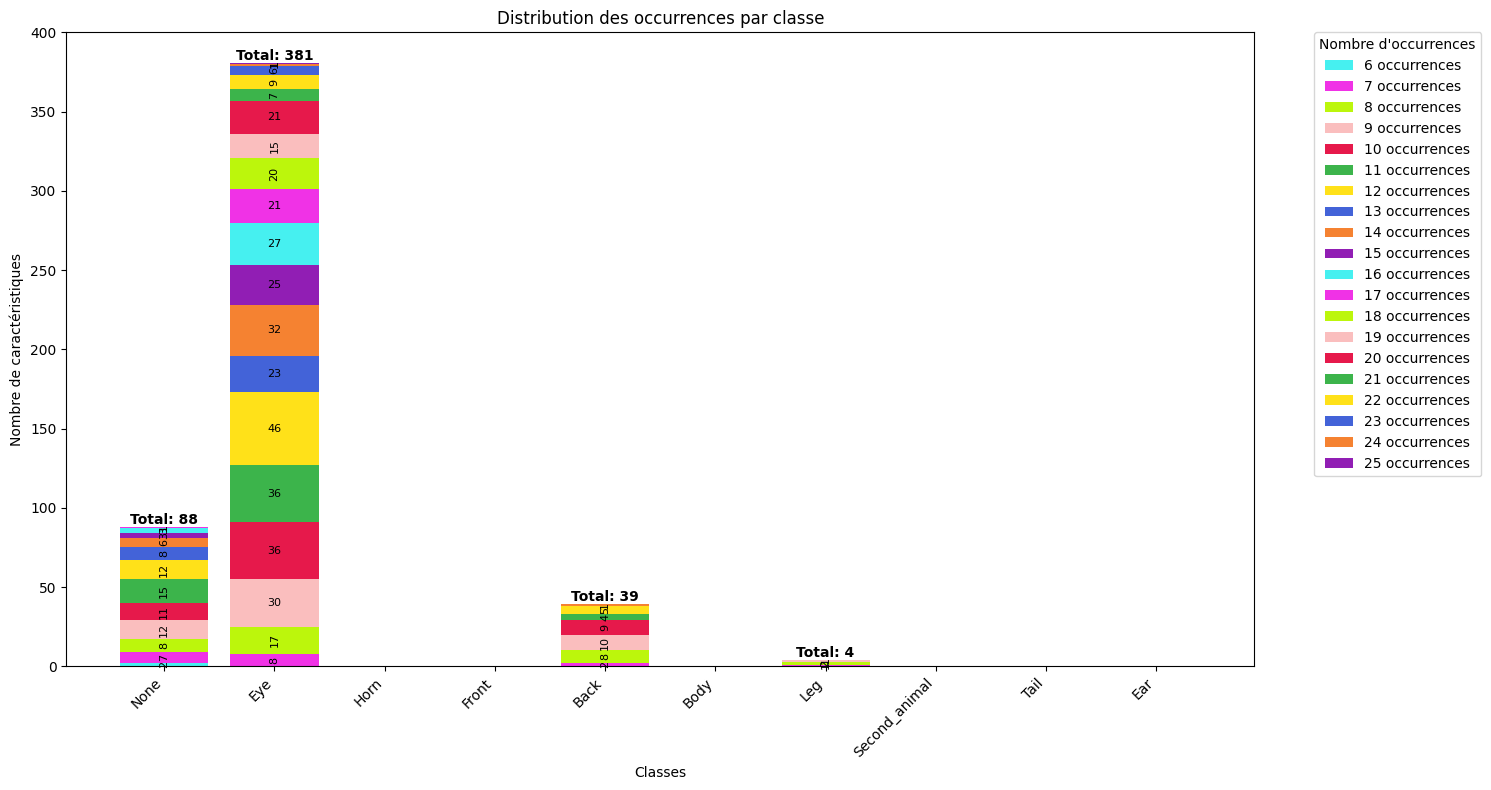

In [63]:
compare_X_dict(dictionnary_file_to_clusters_meaning, dictionary_file_to_index_in_each_cluster, all_values, list_colors=colors, dictionary_class_index=dictionary_class_index, seuil_to_None = 0, base_path = base_path, save_name_prefix = "t1")

DEssous : si apparait une fois : déplacer dans None cluster

Nombre total de features initial: 12800
Nombre de features uniques traitées: 512
Seuil utilisé pour None: 12
Nombre de features assignées: 512
None: 303 features
Eye: 208 features
Horn: 0 features
Front: 0 features
Back: 1 features
Body: 0 features
Leg: 0 features
Second_animal: 0 features
Tail: 0 features
Ear: 0 features
Saved occurrences per class to: ./data/v6/clusters/clusters_analysis/e1_seuil1_nb_level_occurence_per_class.npz
Saved class and occurrence per feature to: ./data/v6/clusters/clusters_analysis/e1_seuil1_class_and_occurence_per_feature.npz
Saved all features per class to: ./data/v6/clusters/clusters_analysis/e1_seuil1_all_feature_in_each_class.npz

Statistiques totales:
Nombre total de caractéristiques: 512
None: 303 caractéristiques
Eye: 208 caractéristiques
Horn: 0 caractéristiques
Front: 0 caractéristiques
Back: 1 caractéristiques
Body: 0 caractéristiques
Leg: 0 caractéristiques
Second_animal: 0 caractéristiques
Tail: 0 caractéristiques
Ear: 0 caractéristiques


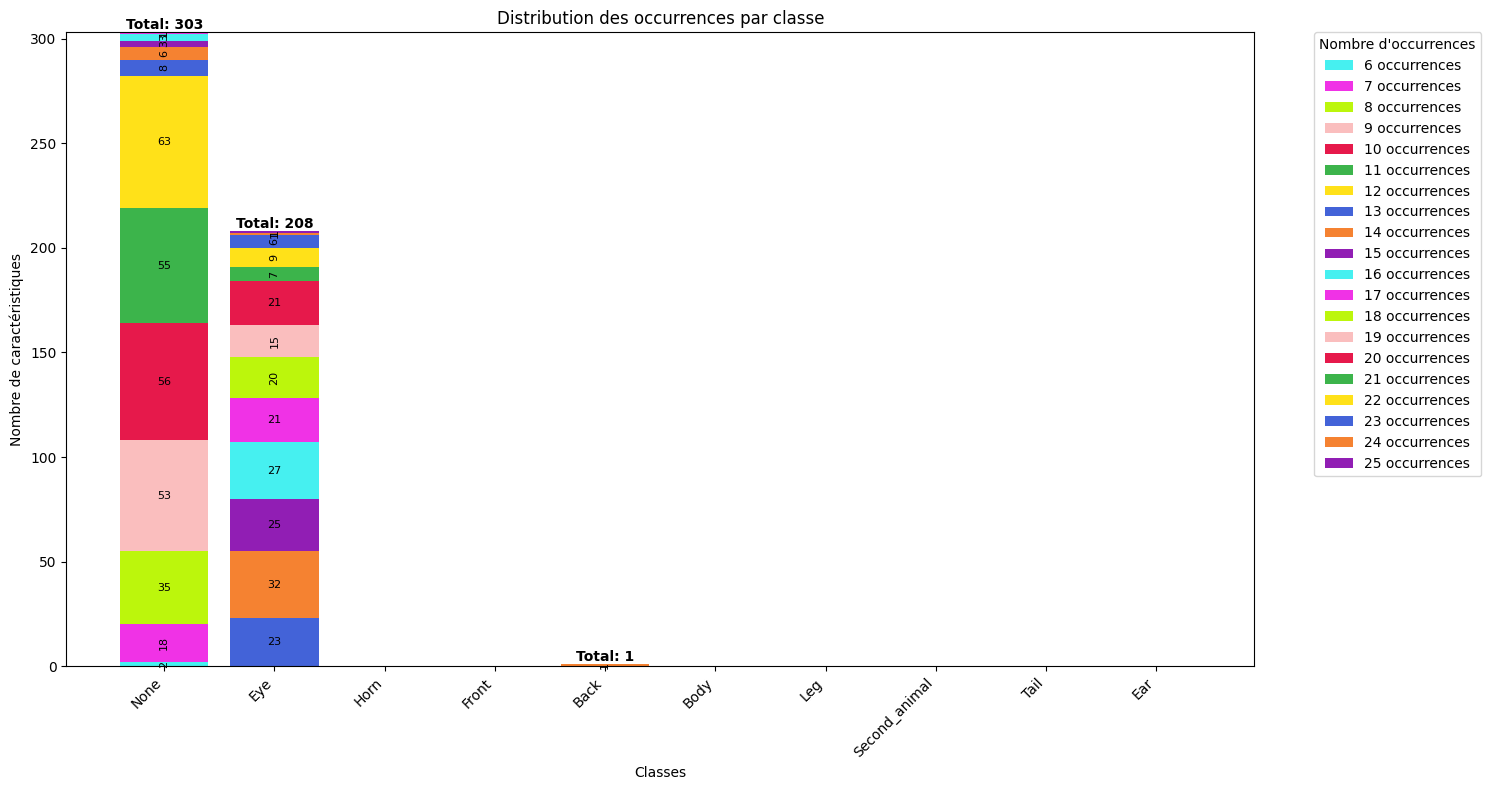

In [64]:
compare_X_dict(dictionnary_file_to_clusters_meaning, dictionary_file_to_index_in_each_cluster, all_values, list_colors=colors, dictionary_class_index=dictionary_class_index, base_path = base_path, save_name_prefix = "e1_seuil1", seuil_is_mean = True)

In [ ]:
compare_X_dictv2(dictionnary_file_to_clusters_meaning, dictionary_file_to_index_in_each_cluster, all_values, list_colors=colors, dictionary_class_index=dictionary_class_index, seuil_to_None = 0, base_path = base_path, save_name_prefix = "t1_new")